In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

# Load the dataset
file_path = '/content/drive/My Drive/Weather-forecast/Filtered_Weather_Data.csv'
df = pd.read_csv(file_path)

# Convert 'date' to pandas datetime format
df['dateime'] = pd.to_datetime(df['datetime'])

# Initialize the MinMaxScaler and scale the features
scaler = MinMaxScaler(feature_range=(0, 1))
df[['temp', 'humidity', 'sealevelpressure']] = scaler.fit_transform(df[['temp', 'humidity', 'sealevelpressure']])

# Function to create sequences including the date for prediction reference
def create_sequences(data, n_steps, forecast_horizon):
    X, y, dates = [], [], []
    for i in range(len(data) - n_steps - forecast_horizon + 1):
        X.append(data.iloc[i:i+n_steps][['temp', 'humidity', 'sealevelpressure']].values)
        y.append(data.iloc[i+n_steps:i+n_steps+forecast_horizon][['temp', 'humidity', 'sealevelpressure']].values.reshape(-1))
        dates.append(data.iloc[i+n_steps:i+n_steps+forecast_horizon]['datetime'].values)
    return np.array(X), np.array(y), np.array(dates)

# Define the number of past observations and forecast horizon
n_steps = 24
forecast_horizon = 6
X, y, dates = create_sequences(df, n_steps, forecast_horizon)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(X, y, dates, test_size=0.2, random_state=42)

# Define the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(n_steps, 3)), # 3 features: temp, humidity, pressure
    LSTM(50),
    Dense(forecast_horizon * 3)  # Output layer for 6 hours x 3 variables
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/100
20/20 [==============================] - 6s 72ms/step - loss: 0.1170 - val_loss: 0.0443
Epoch 2/100
20/20 [==============================] - 1s 27ms/step - loss: 0.0396 - val_loss: 0.0387
Epoch 3/100
20/20 [==============================] - 1s 39ms/step - loss: 0.0344 - val_loss: 0.0340
Epoch 4/100
20/20 [==============================] - 1s 39ms/step - loss: 0.0284 - val_loss: 0.0241
Epoch 5/100
20/20 [==============================] - 1s 40ms/step - loss: 0.0186 - val_loss: 0.0137
Epoch 6/100
20/20 [==============================] - 1s 39ms/step - loss: 0.0120 - val_loss: 0.0101
Epoch 7/100
20/20 [==============================] - 1s 40ms/step - loss: 0.0096 - val_loss: 0.0088
Epoch 8/100
20/20 [==============================] - 1s 25ms/step - loss: 0.0089 - val_loss: 0.0083
Epoch 9/100
20/20 [==============================] - 0s 24ms/step - loss: 0.0084 - val_loss: 0.0081
Epoch 10/100
20/20 [==============================] - 1s 25ms/step - loss: 0.0081 - val_loss: 0.0078

5/5 [==============================] - 0s 21ms/step
Mean Absolute Error (MAE): 1.9312028855512926
Root Mean Squared Error (RMSE): 2.5731398994831802


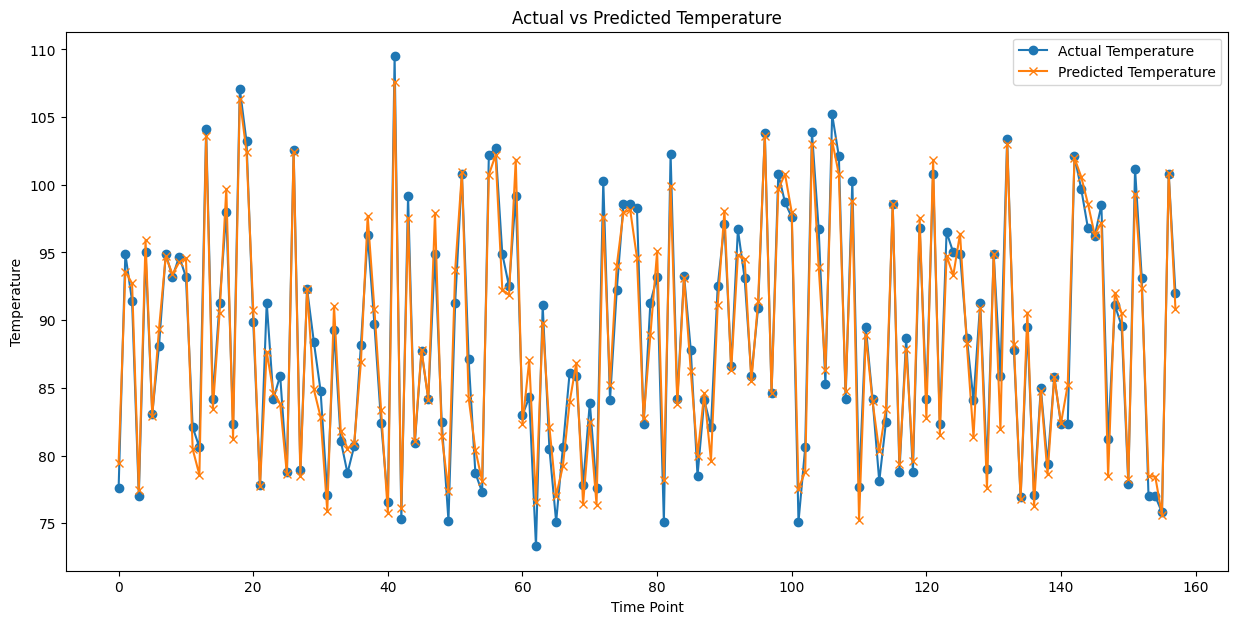

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming 'model', 'X_test', 'y_test', and 'scaler' are already defined and available

# Predict on the test set
y_pred = model.predict(X_test)

# Optionally, reverse the scaling if the targets were scaled
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 3)).reshape(y_pred.shape)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 3)).reshape(y_test.shape)

# Calculate error metrics
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = mean_squared_error(y_test_rescaled, y_pred_rescaled, squared=False)  # Set squared=False for RMSE

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot the actual vs predicted values for one of the features, e.g., temperature
plt.figure(figsize=(15, 7))
plt.plot(y_test_rescaled[:, 0], label='Actual Temperature', marker='o')
plt.plot(y_pred_rescaled[:, 0], label='Predicted Temperature', marker='x')
plt.title('Actual vs Predicted Temperature')
plt.xlabel('Time Point')
plt.ylabel('Temperature')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Load the CSV file containing the last 24 hours of data
data_path = '/content/drive/My Drive/Weather-forecast/filtered_gandhinagar_weather.csv'
df = pd.read_csv(data_path)

# Convert 'date' to pandas datetime format
df['date'] = pd.to_datetime(df['date'])

# Assuming 'scaler' is also already defined and fitted
# Apply the MinMaxScaler used during training
df[['temp', 'humidity', 'sealevelpressure']] = scaler.transform(df[['temp', 'humidity', 'sealevelpressure']])

# Prepare the data for prediction
# Make sure to reshape data to match the input shape expected by the model (1, 24, number of features)
input_data = df[['temp', 'humidity', 'sealevelpressure']].values.reshape(1, 24, 3)

# Use the existing model instance to predict the next 6 hours
predicted = model.predict(input_data)

# Reverse scaling if necessary
predicted_rescaled = scaler.inverse_transform(predicted.reshape(-1, 3)).reshape(predicted.shape)

# Generate future datetime values for each prediction
last_date = df['date'].iloc[-1]
future_dates = pd.date_range(start=last_date, periods=7, freq='H')[1:]  # Excludes the last hour of input, includes next 6 hours

# Display predictions with their corresponding datetime
predicted_output = pd.DataFrame(predicted_rescaled.reshape(6, 3), columns=['Temp', 'Humidity', 'Pressure'])
predicted_output['Datetime'] = future_dates
print(predicted_output)


1/1 [==============================] - 0s 35ms/step
        Temp   Humidity     Pressure            Datetime
0  82.921486  35.790398  1011.340332 2024-03-31 00:00:00
1  80.919685  35.587292  1011.220459 2024-03-31 01:00:00
2  80.777634  38.975540  1010.696167 2024-03-31 02:00:00
3  79.548492  42.354553  1010.385864 2024-03-31 03:00:00
4  78.485718  46.670692  1010.049927 2024-03-31 04:00:00
5  78.182938  51.226357  1010.290771 2024-03-31 05:00:00


In [ ]:
print(predicted_output);

        Temp   Humidity     Pressure            Datetime
0  82.921486  35.790398  1011.340332 2024-03-31 00:00:00
1  80.919685  35.587292  1011.220459 2024-03-31 01:00:00
2  80.777634  38.975540  1010.696167 2024-03-31 02:00:00
3  79.548492  42.354553  1010.385864 2024-03-31 03:00:00
4  78.485718  46.670692  1010.049927 2024-03-31 04:00:00
5  78.182938  51.226357  1010.290771 2024-03-31 05:00:00


In [ ]:
json_data = predicted_output.to_json(orient='records', date_format='iso')
print(json_data);

[{"Temp":82.9214859009,"Humidity":35.790397644,"Pressure":1011.3403320312,"Datetime":"2024-03-31T00:00:00.000"},{"Temp":80.9196853638,"Humidity":35.5872917175,"Pressure":1011.2204589844,"Datetime":"2024-03-31T01:00:00.000"},{"Temp":80.777633667,"Humidity":38.9755401611,"Pressure":1010.6961669922,"Datetime":"2024-03-31T02:00:00.000"},{"Temp":79.5484924316,"Humidity":42.3545532227,"Pressure":1010.3858642578,"Datetime":"2024-03-31T03:00:00.000"},{"Temp":78.4857177734,"Humidity":46.6706924438,"Pressure":1010.0499267578,"Datetime":"2024-03-31T04:00:00.000"},{"Temp":78.1829376221,"Humidity":51.2263565063,"Pressure":1010.2907714844,"Datetime":"2024-03-31T05:00:00.000"}]


In [2]:
# Save the model
model.save('/content/weather_forecast_model.h5')

NameError: name 'model' is not defined

In [ ]:
# URL of your Node.js server endpoint expecting the POST request
url = ' https://8674-43-241-193-75.ngrok-free.app/api/predictions'
# Send the POST request with JSON data
headers = {'Content-Type': 'application/json'}
response = requests.post(url, data=json_data, headers=headers)
# Check response from the server
if response.status_code == 200:
    print('Data successfully sent to the server!')
else:
    print('Failed to send data. Response code:', response.status_code, 'Response message:', response.text)


Data successfully sent to the server!
